## 📦 Import Libraries

In [2]:
from data_utils import *
from base_model_utils import *
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import tensorflow as tf
from google.colab import files

## 📊 Data Loading and Preprocessing


In [3]:
!kaggle datasets download -d mohitsingh1804/plantvillage

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
100% 816M/818M [00:36<00:00, 22.3MB/s]
100% 818M/818M [00:36<00:00, 23.2MB/s]


In [4]:
!unzip -q /content/plantvillage.zip

📁 Dataset Restructuring and Filtering
Separated dataset into individual folders per plant.
Only included plants with more than one disease class.
Skipped single-class plants: Raspberry, Blueberry, Orange, Squash, Soybean.


In [5]:
restruct_dataset('/content/PlantVillage')

Processed Cherry_(including_sour): 2 classes.
Processed Tomato: 10 classes.
Skipping Raspberry because it has only one class.
Processed Pepper_bell: 2 classes.
Processed Strawberry: 2 classes.
Processed Corn_(maize): 4 classes.
Processed Apple: 4 classes.
Processed Peach: 2 classes.
Skipping Orange because it has only one class.
Skipping Squash because it has only one class.
Processed Potato: 3 classes.
Skipping Blueberry because it has only one class.
Skipping Soybean because it has only one class.
Processed Grape: 4 classes.
Dataset creation complete.


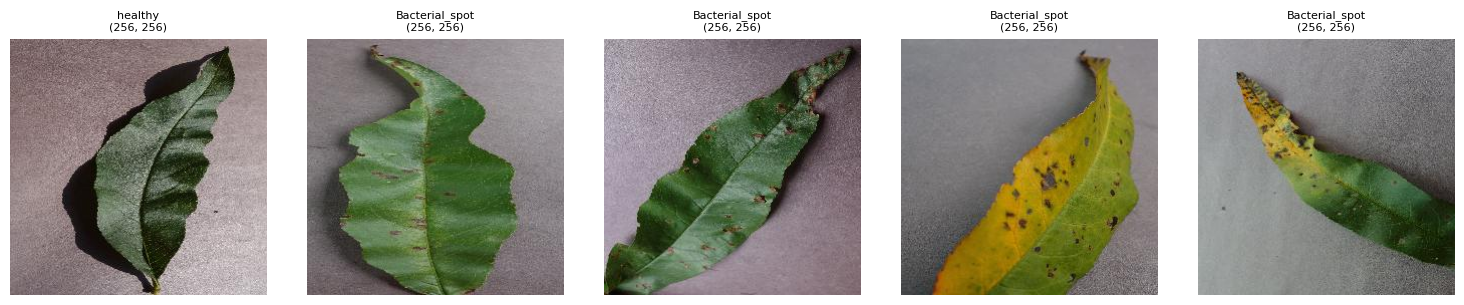

In [57]:
show_random_images('Peach')

# 🔄 Loading Data Generators

In [58]:
Peach_train_generator, Peach_val_generator, Peach_test_generator = load_data_generator('Peach')

Found 1992 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


# 🍑 Building the Specialized Model for Peach


In [59]:
base_model = load_base_model()

In [60]:
def build_specialized_model(base_model, num_classes):
    inputs = Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    model.summary()
    return model


In [61]:
Peach_model = build_specialized_model(base_model, num_classes=2)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 2, 2, 256)           │         390,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,490 (1.62 MB)

 Trainable params: 328,834 (1.25 MB)

 Non-trainable params: 94,656 (369.75 KB)

In [62]:
plateau_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.995 and logs.get('val_accuracy') >= 0.99:
            print("\nReached 99% accuracy. Stopping training!")
            self.model.stop_training = True


callback = MyCallback()


# 🏋️ Start Training the Model


In [63]:
Peach_histo = Peach_model.fit(
    Peach_train_generator,
    epochs=25,
    validation_data=Peach_val_generator,
    callbacks=[plateau_scheduler, callback]
    )

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.9503 - loss: 0.1288 - val_accuracy: 0.8757 - val_loss: 0.2956 - learning_rate: 1.0000e-04
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9948 - loss: 0.0187 - val_accuracy: 0.9718 - val_loss: 0.0693 - learning_rate: 1.0000e-04
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9964 - loss: 0.0099 - val_accuracy: 0.9887 - val_loss: 0.0298 - learning_rate: 1.0000e-04
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9991 - loss: 0.0053
Reached 99% accuracy. Stopping training!
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9962 - val_loss: 0.0124 - learning_rate: 1.0000e-04


# 📈 Visualizing Model Training Performance


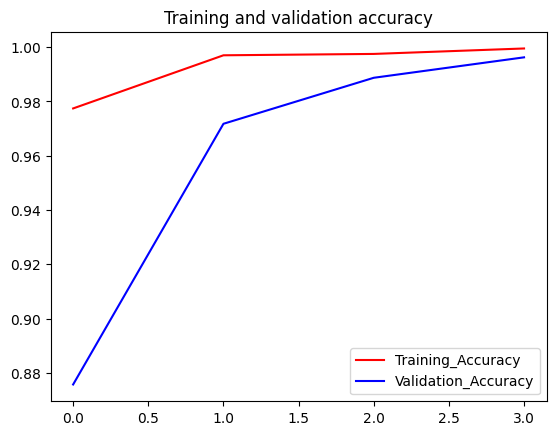

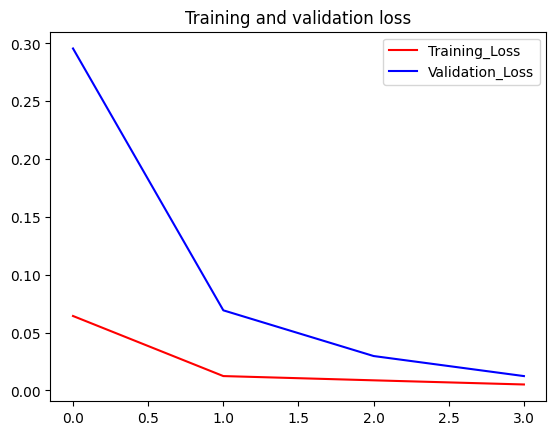

<Figure size 640x480 with 0 Axes>

In [64]:
Peach_train_accuracy = Peach_histo.history.get('accuracy')
Peach_val_accuracy = Peach_histo.history.get('val_accuracy')

Peach_train_loss = Peach_histo.history.get('loss')
Peach_val_loss = Peach_histo.history.get('val_loss')

epochs = range(len(Peach_train_accuracy))

plt.plot(epochs, Peach_train_accuracy, 'r', label='Training_Accuracy')
plt.plot(epochs, Peach_val_accuracy, 'b', label='Validation_Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, Peach_train_loss, 'r', label='Training_Loss')
plt.plot(epochs, Peach_val_loss, 'b', label='Validation_Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

# 📊 Model Evaluation and Confusion Matrix


In [65]:
Peach_model.evaluate(Peach_test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - accuracy: 0.9943 - loss: 0.0123


[0.01541651040315628, 0.9925373196601868]

In [66]:
steps = len(Peach_test_generator)

x_all = []
y_all = []

for i in range(steps):
    x_batch, y_batch = Peach_test_generator[i]
    x_all.append(x_batch)
    y_all.append(y_batch)

x_all = np.concatenate(x_all)
y_all = np.concatenate(y_all)

y_true = np.argmax(y_all, axis=1)
y_pred = np.argmax(Peach_model.predict(x_all), axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


In [67]:
target_names = list(Peach_test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

                precision    recall  f1-score   support

Bacterial_spot       0.99      1.00      1.00       116
       healthy       1.00      0.94      0.97        18

      accuracy                           0.99       134
     macro avg       1.00      0.97      0.98       134
  weighted avg       0.99      0.99      0.99       134



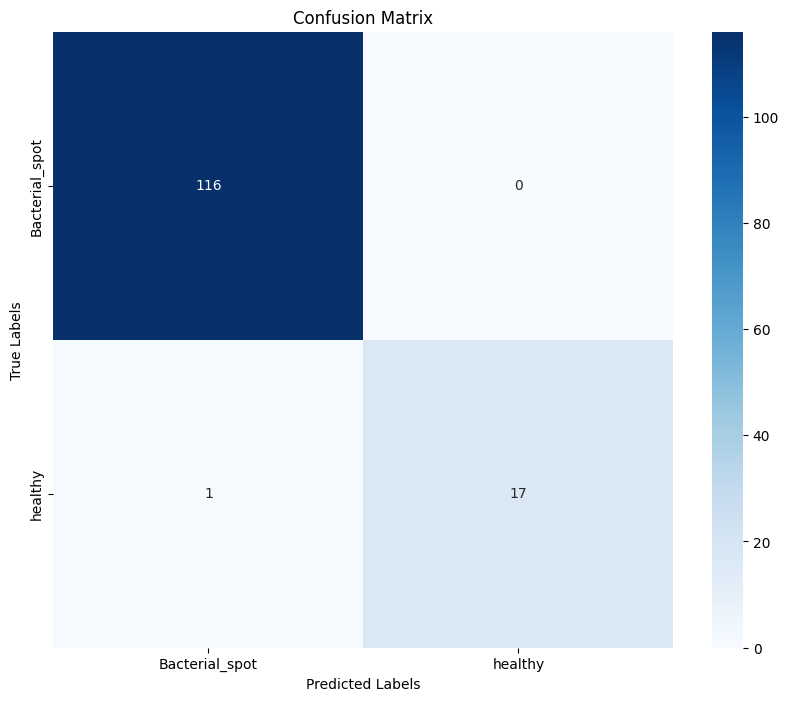

In [68]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Peach_test_generator.class_indices.keys(), yticklabels=Peach_test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 🔨 Quantizing and Converting the Model to TFLite


In [69]:
Model.save(Peach_model, "Peach_model.h5")

In [ ]:
def get_quantized_model(model_name):
    model = tf.keras.models.load_model(model_name+".h5")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    quantized_tflite_model = converter.convert()

    with open(f"{model_name}.tflite", "wb") as f:
        f.write(quantized_tflite_model)

model_name = "Peach_model"
get_quantized_model("Peach_model")


Saved artifact at '/tmp/tmp4fa8mf5i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132539292323664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539292323856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539291120272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539291119888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539292322704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539291122192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539291107600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132539291120656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132537629460624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132537629467920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325376294604

# 🧠 Model Inference with TFLite

In [71]:
interpreter = tf.lite.Interpreter(model_path='Peach_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]['index']
output_index = output_details[0]['index']

In [74]:
image = Image.open('/content/Bacterial_spot.jpeg').resize((150, 150))
input_data = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, axis=0)

interpreter.set_tensor(input_index, input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_index)
predicted_class = np.argmax(output_data)
print("Predicted class:", target_names[predicted_class])


Predicted class: Bacterial_spot


In [73]:
files.download('Peach_model.h5')
files.download("Peach_model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>